### Example Walkthrough - FESOM2 soufflet with spatial hashing
In this example, we walk through the use of spatial hashing to locate the elements that a set of particles reside in.

In [ ]:
! git clone https://github.com/FESOM/fesom2 ./fesom2

#### Reading in the mesh


In [1]:
# Define the function used for reading in the FESOM2 ASCII mesh files
# From an email exchange with Nikolay Kuldonov (nikolay.koldunov@awi.de)
def load_ascii_mesh(mesh_path):
    """
    Loads the mesh data from the specified path and returns the node coordinates and element connectivity.
    FESOM specific function.

    Args:
        mesh_path (str): The path to the directory containing the model output.

    Returns:
        xr.Dataset: Dataset containing the x-coordinates, y-coordinates, and element connectivity array.

    """
    import pandas as pd
    import numpy as np
    import xarray as xr
    
    nodes = pd.read_csv(
        mesh_path + "/nod2d.out",
        sep="\\s+",
        skiprows=1,
        names=["node_number", "x", "y", "flag"],
    )

    x2 = nodes.x.values
    y2 = nodes.y.values

    file_content = pd.read_csv(
        mesh_path + "/elem2d.out",
        sep="\\s+",
        skiprows=1,
        names=["first_elem", "second_elem", "third_elem"],
    )

    x2 = np.where(x2 > 180, x2 - 360, x2)

    elem = file_content.values - 1

    ds = xr.Dataset(
        {
            "x": (("nod2"), x2),
            "y": (("nod2"), y2),
            "elements": (("elem", "n3"), elem),
        }
    )

    return ds

In [2]:
# Load the mesh

mesh_ds = load_ascii_mesh( "./fesom2/test/meshes/soufflet/")


#### Handling periodic boundary conditions
When calculating the diagonals, we need to be careful about periodic domains. The element connectivity is specified to include periodic boundary conditions. This can cause problems with bounding box diagonal calculation or edge length calculation. For example, in an x-periodic domain, elements with vertices on the left most edge of the domain will be connected to elements with vertices on the right most edge of the domain. For these elements, the edge lengths will span the length of the domain, which can artifically increase our measure of the bounding box diagonal length. To avoid this, we use the median bounding box diagonal, rather than the mean to determine the representative size of the hash cells.

**Note** 
Ultimately, we will want to pre-process any mesh that has periodicity. Specicifically, we will need to set up ghost-vertices on the mesh perimeter, connect elements that have periodicity to the ghost vertices, and re-index with the ghost vertices added. From here, we would need a way to also track a "parent-child" relationship between the ghost and original vertices. 

For now, we'll purge these elements from the mesh.


In [3]:
def purge_periodic_elements(vertices, elements, fac=1.0):
    """
    Creates a new list of elements by removing elements that are on periodic boundaries
    
    Parameters:
    - vertices (np.ndarray): Array of vertex coordinates of shape (n_vertices, 2).
    - elements (np.ndarray): Array of element-to-vertex connectivity, where each row contains 3 indices into the vertices array.
    
    Returns:
    - cell_size (float): The recommended hash cell size.
    """
    # Initialize a list to store bounding box diagonals
    diagonals = np.zeros(elements.shape[0])

    # Loop over each triangle element
    k = 0
    for triangle in elements:
        # Get the coordinates of the triangle's vertices
        triangle_vertices = vertices[triangle]
        
        # Calculate the bounding box of the triangle
        x_min, y_min = np.min(triangle_vertices, axis=0)
        x_max, y_max = np.max(triangle_vertices, axis=0)
        
        # Calculate the diagonal length of the bounding box
        diagonal = np.sqrt((x_max - x_min) ** 2 + (y_max - y_min) ** 2)
        
        # Store the diagonal length
        diagonals[k] = diagonal

        k+=1

    median_diag = np.median(diagonals)
    print(f"median diag : {median_diag}")
    n_new_elements = np.sum((diagonals < fac*median_diag))
    new_elements = np.zeros((n_new_elements,3),dtype=int)
    k = 0
    j = 0
    for triangle in elements:
        if diagonals[k] < fac*median_diag :
            new_elements[j,:] = triangle
            j+=1
        k+=1
        

    return new_elements

import numpy as np

x_v = mesh_ds.x.to_numpy()
y_v = mesh_ds.y.to_numpy()
elements = mesh_ds.elements.to_numpy()

nelems_initial = elements.shape[0]
# Calculate hash cell size
vertices = np.column_stack((x_v,y_v))
elems = purge_periodic_elements(vertices,elements,fac=1.2)
nelems_new = elems.shape[0]

print(f"Removed {nelems_initial - nelems_new} elements from mesh for periodicity")
print(f"Number of elements : {nelems_new}")


median diag : 0.23891506859133
Removed 228 elements from mesh for periodicity
Number of elements : 5472


#### Creating the hash cells
Now we want to create the hash cells for spatial hashing. The hash cells are determined by their lower left vertex and their size. Since we are assuming at the moment the hash cells are isotropic and their size is constant in the mesh, we simply need to know the lower left vertex in the mesh and the cell size.

Here, the hash cell size is using a length that is proportional to the median diagonal length of the bounding box for each triangle. The `calculate_hash_cell_size` function takes in a list of vertices, the element connectivity, and a scale factor and returns the hash cell size. The hash cell size is the scale factor multiplied by the median element bounding box diagonal.

In [11]:
def calculate_hash_cell_size(vertices, elements, scalefac=1.0):
    """
    Calculate the hash cell size based on the median bounding box diagonal length of all triangles in the mesh.
    
    Parameters:
    - vertices (np.ndarray): Array of vertex coordinates of shape (n_vertices, 2).
    - elements (np.ndarray): Array of element-to-vertex connectivity, where each row contains 3 indices into the vertices array.
    - scalefac (float): Multiplier for the median triangle diagonal length to set the hash cell size
    
    Returns:
    - cell_size (float): The recommended hash cell size.
    """
    import numpy as np
    
    # Initialize a list to store bounding box diagonals
    diagonals = np.zeros(elements.shape[0])

    # Loop over each triangle element
    k = 0
    for triangle in elements:
        # Get the coordinates of the triangle's vertices
        triangle_vertices = vertices[triangle]
        
        # Calculate the bounding box of the triangle
        x_min, y_min = np.min(triangle_vertices, axis=0)
        x_max, y_max = np.max(triangle_vertices, axis=0)
        
        # Calculate the diagonal length of the bounding box
        diagonal = np.sqrt((x_max - x_min) ** 2 + (y_max - y_min) ** 2)
        
        # Store the diagonal length
        diagonals[k] = diagonal

        k+=1
    
    print(f"Minimum diagonal : {np.min(diagonals)}")
    print(f"Maximum diagonal : {np.max(diagonals)}")
    print(f"Mean diagonal    : {np.mean(diagonals)}")
    print(f"Median diagonal  : {np.median(diagonals)}")
    
    # Use the median diagonal as a basis for the cell size
    cell_size = np.median(diagonals)*scalefac
    
    return cell_size

# Calculate hash cell size
hash_cell_size = calculate_hash_cell_size(vertices, elems,0.1)
print( f"Hash cell size : {hash_cell_size}")

Minimum diagonal : 0.23884932488914404
Maximum diagonal : 0.23891506859133285
Mean diagonal    : 0.23888911712994101
Median diagonal  : 0.23891506859132997
Hash cell size : 0.023891506859132997


#### Relating the the unstructured mesh elements to the hash cells
Now that we have the hash cell size, we now want to create a lookup table where we can put in the hash cell indices `(i,j)` and retrieve a list of elements whose bounding boxes overlap the hash cells. This way, when we want to map the particle positions to the triangular element id's we can first do a fast lookup against the hash cells. Once we have the hash cell id for the particle position, we can get a short list of triangles that we can use to check if the particle resides in.



In [12]:
def get_triangles_in_hash_cells(nxh, nyh, vertices, elements, cell_size):
    """
    Efficiently find the list of triangles whose bounding box overlaps with the specified hash cells.
    
    Parameters:
    - nxh (int) : The number of hash cell vertices in the x-direction
    - nyh (int) : The number of hash cell vertices in the y-direction
    - vertices (np.ndarray): Array of vertex coordinates of shape (n_vertices, 2).
    - elements (np.ndarray): Array of element-to-vertex connectivity, where each row contains 3 indices into the vertices array.
    - cell_size (float): The size of each hash cell (assumed square, with width and height equal to cell_size).
    
    Returns:
    - overlapping_triangles (dict): A dictionary where keys are the hash cell index and values are lists of triangle indices.
    """
    import numpy as np
    
    overlapping_triangles = [[] for i in range(nxh*nyh)]
    
    # Loop over each triangle element
    for triangle_idx, triangle in enumerate(elements):
        # Get the coordinates of the triangle's vertices
        triangle_vertices = vertices[triangle]
        
        # Calculate the bounding box of the triangle
        x_min, y_min = np.min(triangle_vertices, axis=0)
        x_max, y_max = np.max(triangle_vertices, axis=0)
        
        # Find the hash cell range that overlaps with the triangle's bounding box
        i_min = int(np.floor(x_min / cell_size))
        i_max = int(np.floor(x_max / cell_size))
        j_min = int(np.floor(y_min / cell_size))
        j_max = int(np.floor(y_max / cell_size))
        
        # Iterate over all hash cells that intersect the bounding box
        for j in range(j_min, j_max + 1):
            for i in range(i_min, i_max + 1):
                overlapping_triangles[i+nxh*j].append(triangle_idx)
                    
    return overlapping_triangles


The hash cells are defined by their lower left corner and their size. Here, we are assuming the hash cells are squares. To create the hash cells, we first define the bounding box of the domain spanned by the unstructured mesh. From this and the hash cell size, we can determine the number of hash cells in the mesh. Since the hash cells are non-overlapping elements in a structured grid, we can easily generate a unique integer for each hash cell `idx = i + nxh*j` where `i` is the index in the `x` direction and `j` is the index in the `y` direction. This allows us to create a hash table that takes a unique integer `idx` and returns the list of elements that overlap the hash cell.

To make calculation of the `i` and `j` indices simple, the hash cell grid is assumed to have an origin at `(0,0)`. Consquently, the unstructured grid is shifted so that its origin is also at `(0,0)`.

When using spatial hashing to determine which unstructured element a particle resides in, we have to first map the particle to the hash cell. This is inexpensive since calculating `idx` is reduced to calculating `i = floor(xp / cell_size)` and `j = floor(xp / cell_size)`. Once we have the hash cell that the particle resides in, we then look through the list of elements associated with that hash cell and perform checks to determine which element the particle is in. This is typically done by calculating the barycentric coordinates for the particle and checking if this places the particle inside or outside the element. This is more computationally expensive than the hash cell lookup.

With this in mind, we want to get a feel for the number of triangular elements associated with each hash cell. After creating the hash table, the end of the code snippet below looks into the distribution of triangles per hash cell.

Domain size (Lx,Ly) : (4.41,17.9049)
Number of hash cells (nxh,nyh) : (185,750)
Check min vertex position : [0. 0.]
Minimum triangle count per hash cell : 1.0
Maximum triangle count per hash cell : 6.0
Median triangle count per hash cell  : 2.0
Number of non-empty hash cells       : 138750 ( 100.0 %)


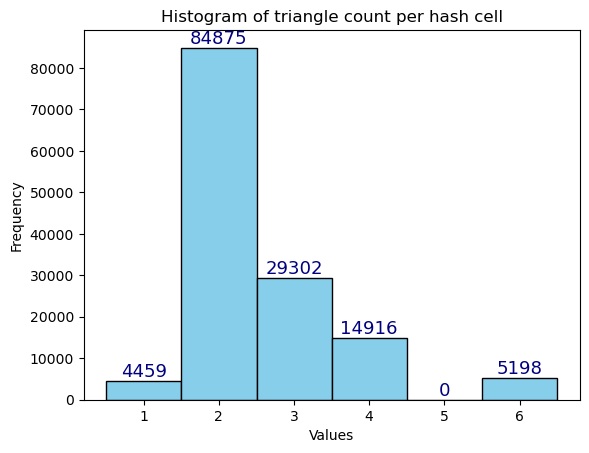

In [18]:
import matplotlib.pyplot as plt
# Get the bounding box for the domain
x_min, y_min = np.min(vertices, axis=0)
x_max, y_max = np.max(vertices, axis=0)

# To determine how many hash cells we need, we divide the domain length by the hash_cell_size
Lx = (x_max-x_min)
Ly = (y_max-y_min)
print( f"Domain size (Lx,Ly) : ({Lx},{Ly})")
nxh = int(np.ceil(Lx/hash_cell_size))
nyh = int(np.ceil(Ly/hash_cell_size))
print( f"Number of hash cells (nxh,nyh) : ({nxh},{nyh})")

# The vertices are required to share an origin in the lower left corner with the hash map.
# Since the hash map is assumed to start at (0,0), then the vertices are translated so that
# the (x_min,y_min) = (0,0)
vertices[:,0] = vertices[:,0] - x_min
vertices[:,1] = vertices[:,1] - y_min
print(f"Check min vertex position : {np.min(vertices, axis=0)}")

triangles_hashmap = get_triangles_in_hash_cells(nxh,nyh,vertices,elems,hash_cell_size)

## Count how many triangles are in each hash cell.
hashmap_triangle_count = np.zeros(len(triangles_hashmap))
k=0
for t in triangles_hashmap:
    hashmap_triangle_count[k]=len(t)
    k+=1

nnonzero = np.count_nonzero(hashmap_triangle_count)
print(f"Minimum triangle count per hash cell : {np.min(hashmap_triangle_count)}")
print(f"Maximum triangle count per hash cell : {np.max(hashmap_triangle_count)}")
print(f"Median triangle count per hash cell  : {np.median(hashmap_triangle_count)}")
print(f"Number of non-empty hash cells       : {nnonzero} ( {nnonzero/len(triangles_hashmap)*100.0} %)")

# Plotting a basic histogram
bin_edges = np.arange( np.min(hashmap_triangle_count)-0.5, np.max(hashmap_triangle_count)+1.5,1)
values, bins, bars = plt.hist(hashmap_triangle_count, bins=bin_edges, color='skyblue', edgecolor='black',align='mid')
plt.bar_label(bars, fontsize=13, color='navy')
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of triangle count per hash cell')
 
# Display the plot
plt.show()

For this simple example, we see that we have 185x750 (138,750) hash cells. The majority (8602) of the hash cells are associated with two triangles. 

Some experimentation has found that the distribution of triangle count per hash cell is sensitive to the size of the hash cell (which is influenced by the diagonal scale factor). At the moment, it's unclear how important this is for the performance of the method.

#### Aligning the particles with a hash cell
Now that we have the hash map defined and we have associated a list of triangle elements with each hash cell, we can now start working on the search method to map a particle position to an element. The first step in this process is to map the particle position to the hash cell.

As mentioned previously, calculating the hash cell that each particle resides in is fairly straightforward. Given a list of `x` and `y` positions for particles, we can calculate `i = int(floor( x / cell_size ))` and `j = int(floor( y / cell_size ))`. To calculate the unique integer for the hash table lookup, we simply set the hash table id to `idx = i + nxh*j` for each particle. 



In [19]:
def get_particles_in_hash_cells(nxh, nyh, xp, yp, cell_size):
    """
    Efficiently map the particle positions to the hash
    
    Parameters:
    - nxh (int) : The number of hash cell vertices in the x-direction
    - nyh (int) : The number of hash cell vertices in the y-direction
    - xp (np.ndarray): Array of x component of the particle positions (length = np)
    - yp (np.ndarray): Array of y component of the particle positions (length = np)
    - cell_size (float): The size of each hash cell (assumed square, with width and height equal to cell_size).
    
    Returns:
    - particle_hash (np.ndarray(dtype=int)): Array of size (np) that stores the hash cell index for the particles
    """
    import numpy as np
    
    particle_hash = np.zeros(xp.size,dtype=int)

    for k in range(xp.size):
        i = int(np.floor(xp[k] / cell_size))
        j = int(np.floor(yp[k] / cell_size))
        particle_hash[k] = i+nxh*j
        
    return particle_hash


Now that we have the function for associating a hash table index with each particle, let's generate some particles and try it out. Here, we generate arrays for x and y positions of particles using a random uniform distribution of values between `[x_min,x_max]` and `[y_min,y_max]`. These positions are then passed into the `get_particles_in_hash_cells` function which returns an array that is of length `num_particles` and contains the hash cell id associated with each particle.



In [15]:
num_particles = 1000
xp = np.zeros(num_particles)
yp = np.zeros(num_particles)
for k in range(num_particles):
    xp[k] = np.random.uniform(x_min, x_max)
    yp[k] = np.random.uniform(y_min, y_max)

# Get the hash cell ids for the particles
particle_hash_ids =  get_particles_in_hash_cells(nxh, nyh, xp, yp, hash_cell_size)

From the hash id's, note that we can also list the possible elements for each particle that we will want to search. Here, we print a list of possible elements for each particle and show a plot of the particles with the elements and hash cells overlayed; this time, the element id's are shown instead of the hash cell ids.

#### Calculating Barycentric Coordinates
With each particle now having a list of possible elements they could reside in, we now need to develop a check for determining if a particle is inside or outside a triangle. Determining whether a particle is inside or outside a triangle can be done using **barycentric coordinates**. 

Barycentric coordinates provide a convenient way to express any point inside a triangle in terms of the triangle's vertices. The idea is to express a point $( P )$ as a combination of the vertices of the triangle $( A )$, $( B )$, and $( C )$.

Let the vertices of the triangle be:
- $( A = (x_A, y_A) )$
- $( B = (x_B, y_B) )$
- $( C = (x_C, y_C) )$

Given a point $( P = (x_P, y_P) )$, we can determine if it lies inside the triangle by solving for the barycentric coordinates $( \lambda_1, \lambda_2, \lambda_3 )$, such that:

$P = \lambda_1 A + \lambda_2 B + \lambda_3 C$

Geometrically, the value of each coordinate represents the proportional area of the sub-triangle formed by the point P and the opposite edge of the original triangle. If a point lies inside the triangle, all of its barycentric coordinates are between 0 and 1. Mathematically, we can write

$\lambda_1 = Area(BCP)/Area(ABC)$
$\lambda_1 = Area(CAP)/Area(ABC)$
$\lambda_3 = Area(ABP)/Area(ABC)$

The area of a triangle given only three points can be calculated as

$ A = 1/2 ( x_1(y_2-y_3) + x_2(y_3-y_1) + x_3(y_1-y_2))$

All of this is put together in the `barycentric_coordinates` function below, which takes a particle position and a triangular element's vertices and computes the barycentric coordinates. Additionally, it reports if the particle is inside or outside the triangle. 

Here, we'll just look at the first particle and the first element it is associated with to test this out. To get the particle position, we simply take `xp[0]` and `yp[0]`. To get the triangle vertices, we use the particle's hash cell id to obtain the list of triangular elements it may be associated with. We take the first element id from this list and use this to obtain the corresponding vertex ids. From the vertex ids, we obtain the `x` and `y` positions from the `vertices` array.

In [16]:
def barycentric_coordinates(xP, yP, triangle_vertices):
    """
    Compute the barycentric coordinates of a particle in a triangular element
    
    Parameters:
    - xP, yP: The coordinates of the particle
    - triangle_vertices (np.ndarray) : The vertices of the triangle as a (3,2) array.
    
    Returns:
    - The barycentric coordinates (l1,l2,l3)
    - True if the point is inside the triangle, False otherwise.
    """
    
    xv = np.squeeze(triangle_vertices[:,0])
    yv = np.squeeze(triangle_vertices[:,1])

    A_ABC = xv[0]*(yv[1]-yv[2]) + xv[1]*(yv[2]-yv[0]) + xv[2]*(yv[0]-yv[1])
    A_BCP = xv[1]*(yv[2]-yP   ) + xv[2]*(yP   -yv[1]) + xP   *(yv[1]-yv[2])
    A_CAP = xv[2]*(yv[0]-yP   ) + xv[0]*(yP   -yv[2]) + xP   *(yv[2]-yv[0])
    A_ABP = xv[0]*(yv[1]-yP   ) + xv[1]*(yP   -yv[0]) + xP   *(yv[0]-yv[1])

    # Compute the vectors
    l1 = A_BCP/A_ABC
    l2 = A_CAP/A_ABC
    l3 = A_ABP/A_ABC
    
    inside_triangle = all( [l1 >= 0.0, l1 <= 1.0, 
                            l2 >= 0.0, l2 <= 1.0,
                            l3 >= 0.0, l3 <= 1.0] )
    
    return l1,l2,l3,inside_triangle

#### Finding the element the particles are inside of
In general, we want to associate each particle with a triangular element ID. This can be done by looping over the particles and repeating a process similar to what we did above. Instead of just looking at the first possible element obtained from the hash table, we could loop over the elements in the hash table until the particle is found inside the element.

For convenience, we plot the particles in the elements, without the hash cells below


In [20]:
def get_particles_in_elements(xp, yp, vertices, elements, particle_hash, overlapping_triangles):
    """
    
    Parameters:
    - xp (np.ndarray): Array of x component of the particle positions (length = np)
    - yp (np.ndarray): Array of y component of the particle positions (length = np)
    - vertices (np.ndarray): Array of vertex coordinates of shape (n_vertices, 2).
    - elements (np.ndarray): Array of element-to-vertex connectivity, where each row contains 3 indices into the vertices array.
    - particle_hash (np.ndarray(dtype=int)): Array of size (np) that stores the hash cell index for the particles
    - overlapping_triangles (dict): A dictionary where keys are the hash cell index and values are lists of triangle indices.

    Returns:
    - particle_element (np.ndarray): Array that lists for each particle its associated element id (length = np)
    - particle_coordinates (np.ndarray) : Array of barycentric coordinates for each particle (np,3)
    """

    particle_element = np.zeros(xp.size,dtype=np.int32)
    particle_coordinates = np.zeros((xp.size,3))
    
    for k in range(xp.size):
        # Get the hash cell id for the particle
        idx = particle_hash_ids[k]
        
        # Find the first element in the hash table
        # that the particle is inside of
        for eid in triangles_hashmap[idx]:
        
            # From the element, get the vertices
            vertex_ids = elements[eid]
            triangle_vertices = vertices[vertex_ids]
        
            # Get the barycentric coordinates
            l1,l2,l3,is_inside = barycentric_coordinates(xp[k],yp[k],triangle_vertices)
            if is_inside:
                # If the particle is inside this element,
                # store the element id and the barycentric coordinates
                # and break from the eid loop
                particle_element[k] = eid
                particle_coordinates[k,:] = [l1,l2,l3]
                break

    return particle_element, particle_coordinates

# Testing below
p_elems, p_coords = get_particles_in_elements(xp,yp,vertices,elems,particle_hash_ids,triangles_hashmap)


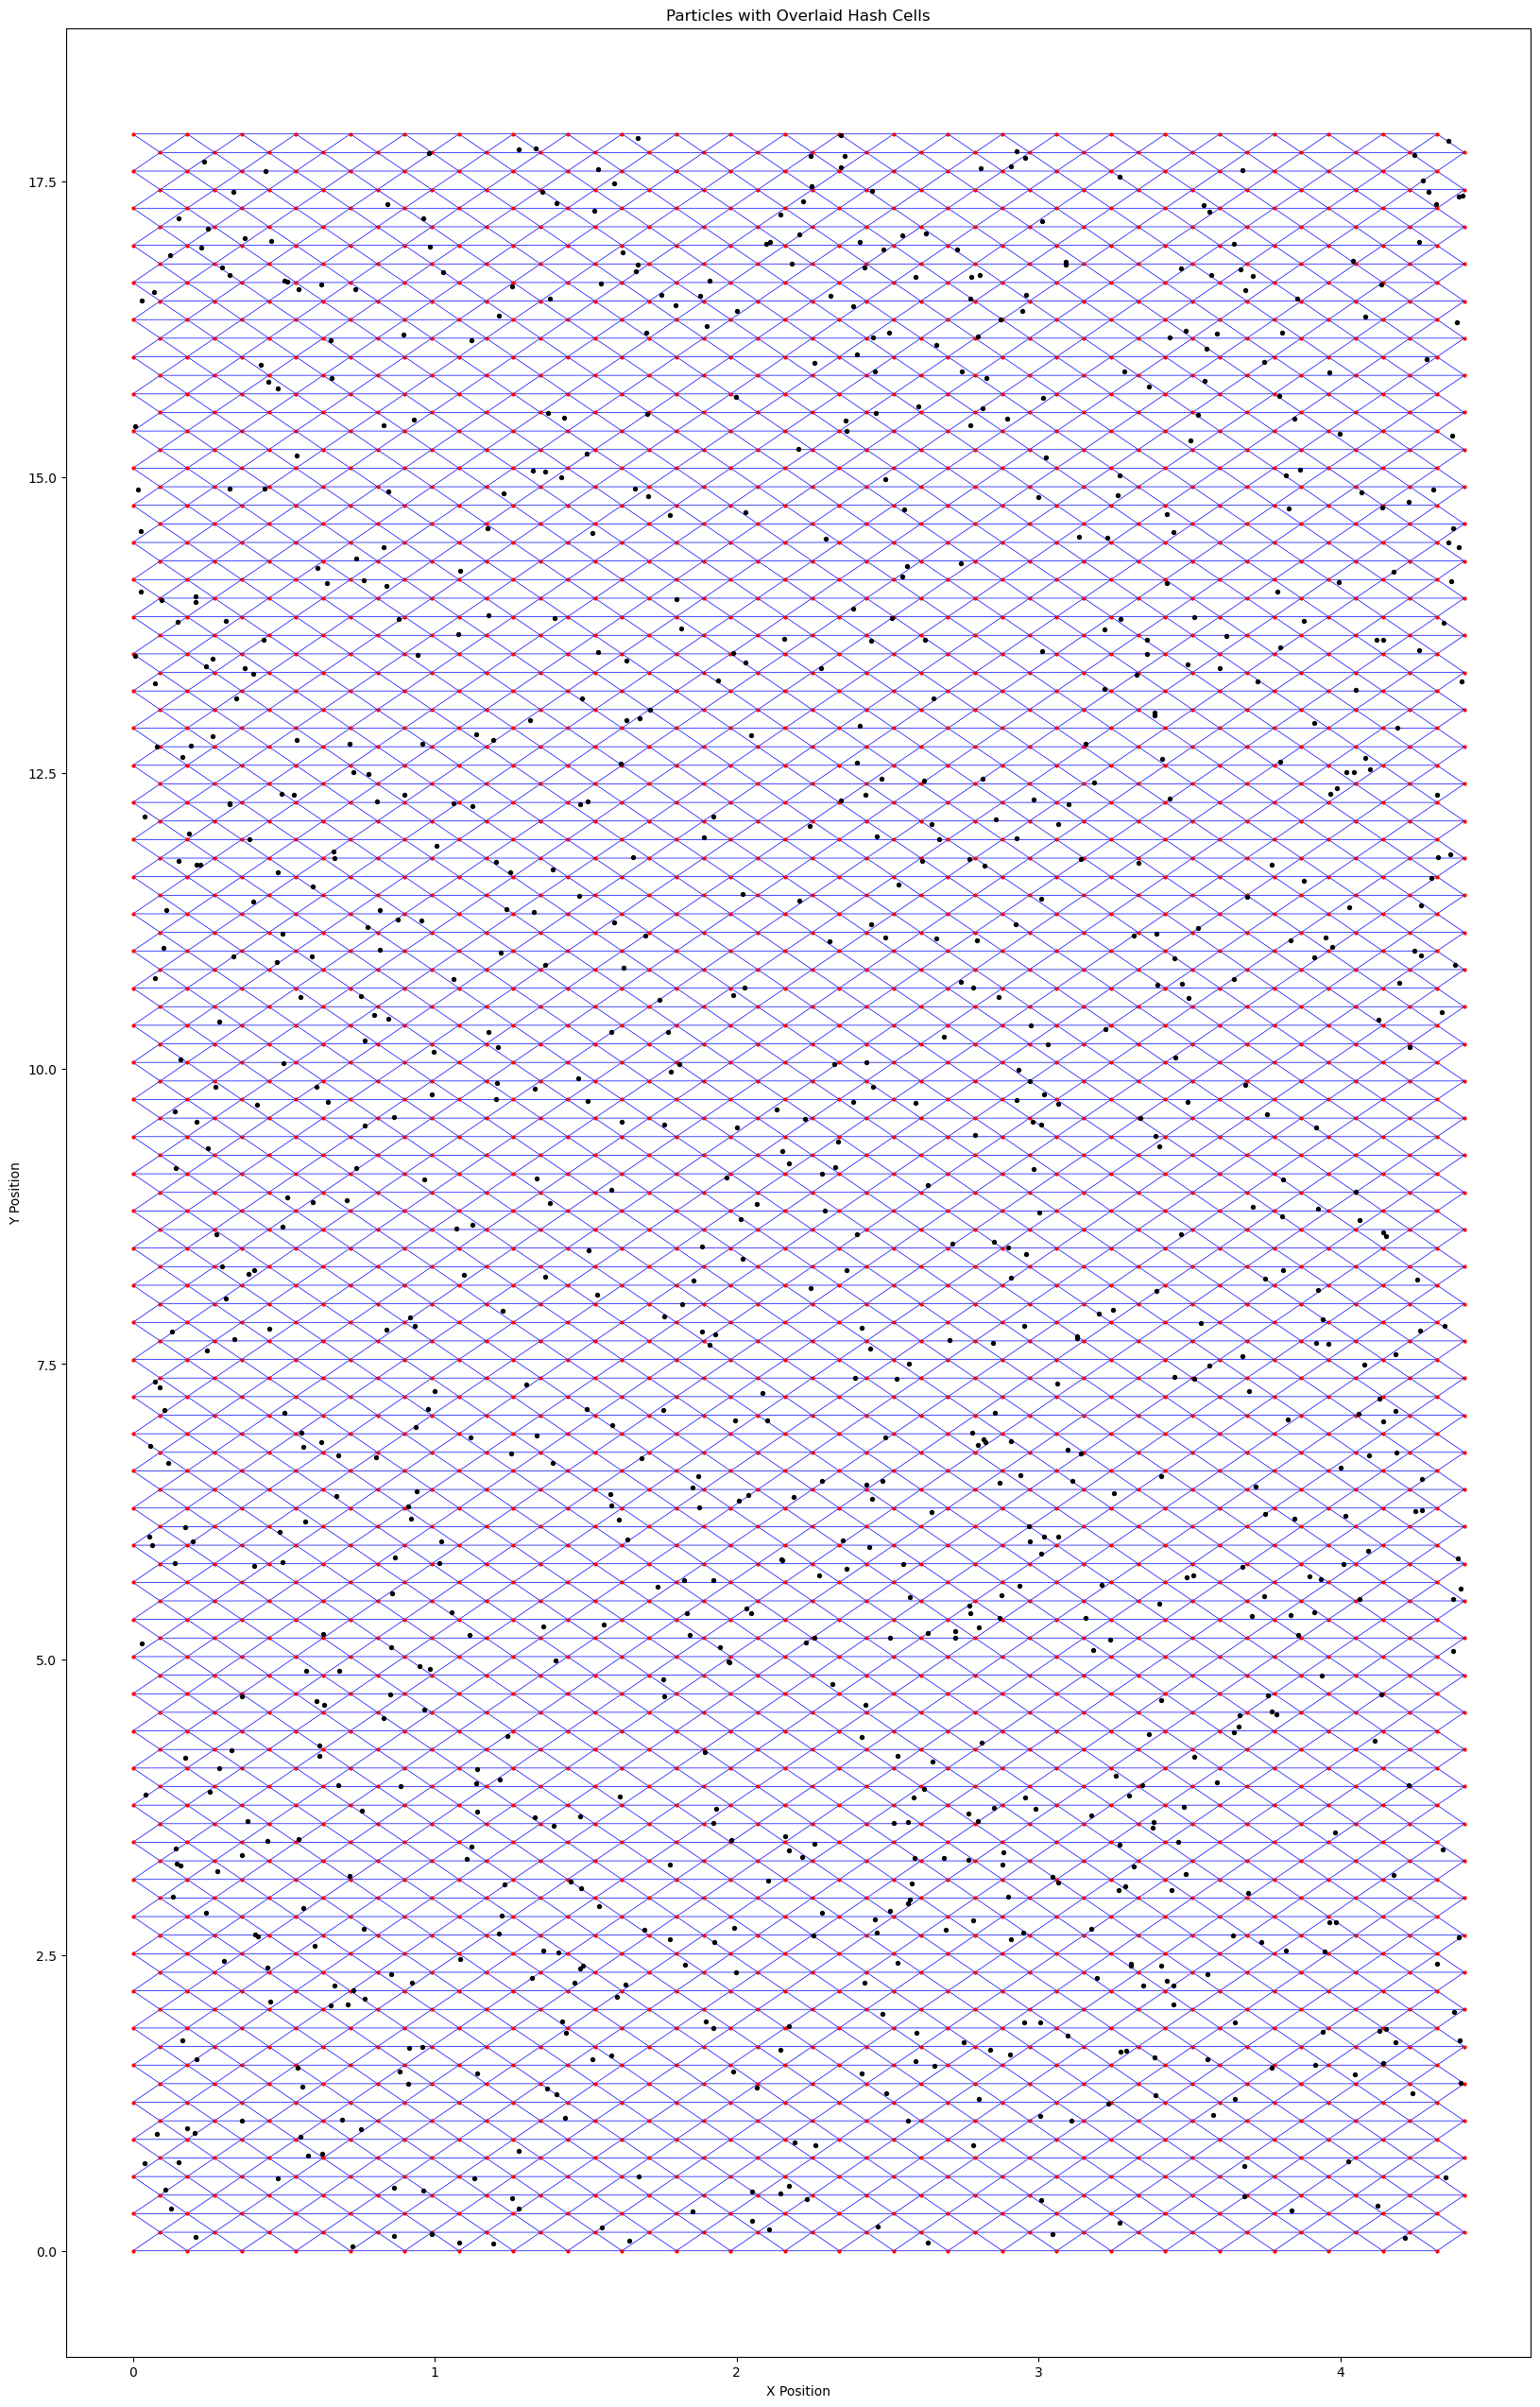

In [25]:
def plot_particles_with_mesh_and_hash_cells(vertices, elements, xp, yp, cell_size, plot_hash_cells=True, annotate_hash_cells=False, annotate_elements=False, annotate_particles=False):
    """
    Plots the particles with the unstructured mesh and hash cells.
    
    Parameters:
    - vertices (np.ndarray): Array of vertex coordinates of shape (n_vertices, 2).
    - elements (np.ndarray): Array of element-to-vertex connectivity, where each row contains 3 indices into the vertices array.
    - xp (np.ndarray): Array of x component of the particle positions (length = np)
    - yp (np.ndarray): Array of y component of the particle positions (length = np)
    - cell_size (float): The size of each hash cell (assumed square, with width and height equal to cell_size).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.tri as tri

    # Create a matplotlib Triangulation object for the mesh
    mesh = tri.Triangulation(vertices[:, 0], vertices[:, 1], elements)

    # Plot the mesh
    plt.figure(figsize=(20,32))
    plt.triplot(mesh, color='blue', lw=0.5)
    plt.scatter(vertices[:, 0], vertices[:, 1], color='red', zorder=5, s=4)
    plt.scatter(xp, yp, color='k', zorder=5, s=8)

    # Get the bounds of the mesh
    x_min, y_min = np.min(vertices, axis=0)
    x_max, y_max = np.max(vertices, axis=0)

    if plot_hash_cells :
        # Generate and plot hash cells
        x_ticks = np.arange(x_min, x_max + cell_size, cell_size)
        y_ticks = np.arange(y_min, y_max + cell_size, cell_size)
    
        # Plot horizontal lines for hash cells
        for y in y_ticks:
            plt.plot([x_min, x_max+cell_size], [y, y], color='black', linestyle='--', lw=0.5)
    
        # Plot vertical lines for hash cells
        for x in x_ticks:
            plt.plot([x, x], [y_min, y_max+cell_size], color='black', linestyle='--', lw=0.5)
    
        if(annotate_hash_cells):
        # Annotate the hash cells (optional, could be cluttered with dense grids)
            for i, x in enumerate(x_ticks[:-1]):
                for j, y in enumerate(y_ticks[:-1]):
                    plt.text(x + 0.5 * cell_size, y + 0.5 * cell_size, f"({i},{j})", 
                             fontsize=8, color='green', ha='center', va='center', zorder=10)
    if(annotate_elements):
        # Loop over each triangle element
        for triangle_idx, triangle in enumerate(elements):
            # Get the coordinates of the triangle's vertices
            triangle_vertices = vertices[triangle]
            xc = np.mean(triangle_vertices[:,0])
            yc = np.mean(triangle_vertices[:,1])
            plt.text(xc, yc, f"({triangle_idx})", 
                         fontsize=8, color='blue', ha='center', va='center', zorder=10)

    if(annotate_particles):
        for k in range(xp.size):
            plt.text(xp[k]+0.08, yp[k]+0.08, f"(p{k})", 
                         fontsize=8, color='black', ha='center', va='center', zorder=10)
            
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Particles with Overlaid Hash Cells')
    #plt.gca().set_aspect('equal')
    plt.grid(False)
    plt.show()

plot_particles_with_mesh_and_hash_cells(vertices,elems,xp,yp,hash_cell_size,plot_hash_cells=False,annotate_particles=False,annotate_elements=False)